In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import time
from IPython import display

import cv2

In [2]:
CWD = Path.cwd()
GENERATED_IMAGES_DIR = CWD/'generated_images'
CHECKPOINT_DIR = GENERATED_IMAGES_DIR/'checkpoints'
SINGLE_IMAGE_DIR = GENERATED_IMAGES_DIR/'single'
COLLAGE_DIR = GENERATED_IMAGES_DIR/'collage'
DATASET_PATH = Path(r'E:\datasets\gan-getting-started')
FOLDERS_TO_SETUP = [
	CHECKPOINT_DIR,
	GENERATED_IMAGES_DIR,
	SINGLE_IMAGE_DIR,
	COLLAGE_DIR
]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
def mkdir(path):
	path.mkdir(exist_ok=True)

In [5]:
def setup_folders(paths: list):
	for path in paths:
		mkdir(path)

In [6]:
def display_image(image):
	plt.imshow(image.astype('uint8'))

#### data preparation

In [7]:
IMAGE_SHAPE = (64, 64, 3)
BATCHSIZE = 32

In [8]:
def normalize_images(images):
	return (images-127.5)/127.5

In [9]:
def denormalize_images(images):
	return np.array((images*127.5+127.5), dtype='uint8')

In [10]:
def resize_images(images, new_size=IMAGE_SHAPE[:-1], interpolation=cv2.INTER_AREA):
	return np.array([cv2.resize(image, new_size, interpolation=interpolation) for image in images], dtype='float32')

In [11]:
def prepare_images():
	images = np.array([plt.imread(image) for image in (DATASET_PATH/'monet_jpg').glob('*')], dtype='float32')
	assert images.shape == (images.shape[0], 256, 256, 3), 'input images have the wrong dimensions!'
	resized_images = resize_images(images)
	normalized_images = normalize_images(resized_images)
	return normalized_images

In [12]:
images = prepare_images()
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]).batch(BATCHSIZE).cache().prefetch(tf.data.AUTOTUNE)

#### model building

##### blocks

In [13]:
from tensorflow.keras import layers

In [14]:
def conv_block(x, n_filters, kernel_size=(3, 3), strides=(2, 2), padding='same'):
	x = layers.Conv2D(n_filters, kernel_size, strides, padding)(x)
	x = layers.LeakyReLU(0.2)(x)
	x = layers.Dropout(0.3)(x)
	return x

In [15]:
def normalized_conv_block(x, n_filters, kernel_size=(3, 3), strides=(2, 2), padding='same'):
	x = layers.Conv2D(n_filters, kernel_size, strides, padding)(x)
	x = layers.LeakyReLU(0.2)(x)
	x = layers.LayerNormalization()(x)
	x = layers.Dropout(0.3)(x)
	return x

In [16]:
def transposed_conv_block(x, n_filters, kernel_size=(3, 3), strides=(2, 2), padding=('same')):
	x = layers.Conv2DTranspose(n_filters, kernel_size, strides, padding, use_bias=False)(x)
	x = layers.LeakyReLU(0.2)(x)
	x = layers.BatchNormalization()(x)
	return x

In [17]:
def get_multiplied_image_dimension(current_dimensions, factor):
	return [dimension*factor for dimension in current_dimensions[-2:-4:-1]]

In [19]:
def resizing_conv_block(x, n_filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
	x = layers.Resizing(*get_multiplied_image_dimension(x.shape, 0.5), interpolation='nearest')(x)
	x = layers.Conv2D(n_filters, kernel_size, strides, padding)
	x = layers.LeakyReLU(0.2)(x)
	x = layers.LayerNormalization()(x)
	return x

In [20]:
def resizing_transposed_conv_block(x, n_filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
	x = layers.Resizing(*get_multiplied_image_dimension(x.shape, 2), interpolation='nearest')(x)
	x = layers.Conv2DTranspose(n_filters, kernel_size, strides, padding)(x)
	x = layers.LeakyReLU(0.2)(x)
	x = layers.BatchNormalization()(x)
	return x

##### models

In [21]:
def wasserstein_loss(y_true, y_pred):
	tf.keras.backend.mean(y_true*y_pred)

In [22]:
class Generator():
	def __init__(self, input_size):
		self.input_size = input_size
		self.optimizer = tf.keras.optimizers.Adam(1e-4, 0, 0.9)
		self.model = self.build()
		
	def __call__(self, inputs, training=False):
		return self.model(inputs, training)
	
	def build(self):
		initial_dimensions = (16, 16)
		inputs = layers.Input(self.input_size)

		x = layers.Dense(np.product(initial_dimensions)*256, use_bias=False)(inputs)
		x = layers.LeakyReLU(0.2)(x)
		x = layers.BatchNormalization()(x)

		x = layers.Reshape((*initial_dimensions, 256))(x)
		
		x = resizing_transposed_conv_block(x, 256)

		outputs = resizing_transposed_conv_block(x, 3)
		# assert outputs.shape == [None, 256, 256, 3], f'output tensor\'s shapes are wrong, {outputs.shape}'

		model = tf.keras.Model(inputs, outputs, name='generator')

		return model
	
	def compute_loss(self, fake_image):
		return -tf.reduce_mean(fake_image)

In [23]:
class Critic():
	def __init__(self, input_size):
		self.input_size = input_size
		self.optimizer = tf.keras.optimizers.Adam(1e-4, 0, 0.9)
		self.model = self.build()
		
	def __call__(self, inputs, training=False):
		return self.model(inputs, training=training)
	
	def build(self):
		inputs = layers.Input(self.input_size)

		x = normalized_conv_block(inputs, 64, (5, 5))
		x = normalized_conv_block(x, 128)

		x = layers.Flatten()(x)
		x = layers.Dropout(0.2)(x)
		outputs = layers.Dense(1)(x)

		model = tf.keras.Model(inputs, outputs, name='critic')

		return model
	
	def compute_loss(self, real_predictions, fake_predictions):
		real_loss = tf.reduce_mean(real_predictions)
		fake_loss = tf.reduce_mean(fake_predictions)
		return fake_loss - real_loss

In [38]:
class WGAN(tf.keras.Model):
	def __init__(self, generator, critic, latent_dim, batchsize=BATCHSIZE, critic_extra_steps=5, alpha=1e-4, beta1=0, beta2=0.9, lambd=10):
		super().__init__()
		self.generator = generator
		self.critic = critic
		self.optimizer = tf.keras.optimizers.Adam(alpha, beta1, beta2)
		self.latent_dim = latent_dim
		self.critic_extra_steps = critic_extra_steps
		self.batchsize = BATCHSIZE
		self.lambd = lambd
		self.last_epoch = 0

	def compute_gradient_penalty(self, generated_images, real_images):
		epsilon = tf.random.uniform((tf.shape(real_images)[0], 1, 1, 1), 0, 1)
		interpolated_generated_images = epsilon * real_images + (1-epsilon) * generated_images

		with tf.GradientTape() as gp_tape:
			gp_tape.watch(interpolated_generated_images)
			prediction = critic(interpolated_generated_images, training=True)

		grads = gp_tape.gradient(prediction, interpolated_generated_images)
		
		# norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3)))

		# in the official paper the formula suggested to be only used on singular examples, therefore omit batchnormalization. This might be an alternative
		# norm = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))))
		# gradient_penalty = self.lambd * tf.square(norm - 1)
		norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3)))
		print(f'norms shape: {tf.shape(norms)}')
		gradient_penalty = self.lambd * tf.reduce_mean(tf.square(norms - 1))
		print(f'gradient penalty shape: {tf.shape(gradient_penalty)}')

		return gradient_penalty

	def train_step(self, images):
		for _ in range(self.critic_extra_steps):
			noise = tf.random.normal(shape=(tf.shape(images)[0], self.latent_dim))
			
			with tf.GradientTape() as tape:
				generated_images = self.generator(noise, training=True)
				fake_predictions = self.critic(generated_images, training=True)
				real_predictions = self.critic(images, training=True)
			
				c_cost = self.critic.compute_loss(real_predictions, fake_predictions)
				gradient_penalty = self.compute_gradient_penalty(generated_images, images)
				c_loss = c_cost + gradient_penalty
		
			c_gradient = tape.gradient(c_loss, self.critic.model.trainable_variables)
			self.critic.optimizer.apply_gradients(zip(c_gradient, self.critic.model.trainable_variables))

		noise = tf.random.normal((self.batchsize, self.latent_dim))
		
		with tf.GradientTape() as tape:
			generated_images = self.generator(noise, training=True)
			fake_predictions = self.critic(generated_images, training=True)
			g_loss = self.generator.compute_loss(fake_predictions)
		
		g_gradient = tape.gradient(g_loss, self.generator.model.trainable_variables)
		self.generator.optimizer.apply_gradients(zip(g_gradient, self.generator.model.trainable_variables))
		
		return {'c_loss': c_loss, 'g_loss': g_loss}

In [25]:
class GANMonitor(tf.keras.callbacks.Callback):
	def __init__(self, latent_dim=100):
		self.latent_dim = latent_dim
		
	def on_epoch_end(self, epoch, logs=None):
		noise = tf.random.normal((12, self.latent_dim))
		generated_images = self.model.generator(noise)
		generated_images = denormalize_images(generated_images)
	
		display.clear_output(True)
		
		f, axs = plt.subplots(3, 4, figsize=(20, 15))
		for i, ax in enumerate(axs.flatten()):
			ax.imshow(generated_images[i])
			ax.axis('off')
		plt.show()
		
		if epoch % 25 == 0:
			checkpoint.save(CHECKPOINT_DIR/'checkpoint')
			
		if epoch % 20 == 0:
			f.savefig(COLLAGE_DIR/f'image_at_epoch_{epoch}.png', format='png', dpi=300)

#### training

In [26]:
LATENT_DIM = 100

In [27]:
gan_monitor = GANMonitor()

In [39]:
generator = Generator(LATENT_DIM)
critic = Critic(IMAGE_SHAPE)
checkpoint = tf.train.Checkpoint(
	generator_optimizer=generator.optimizer,
	critic_optimizer=critic.optimizer,
	generator=generator.model,
	critic=critic.model
)

In [40]:
wgan = WGAN(generator, critic, LATENT_DIM)
wgan.compile()

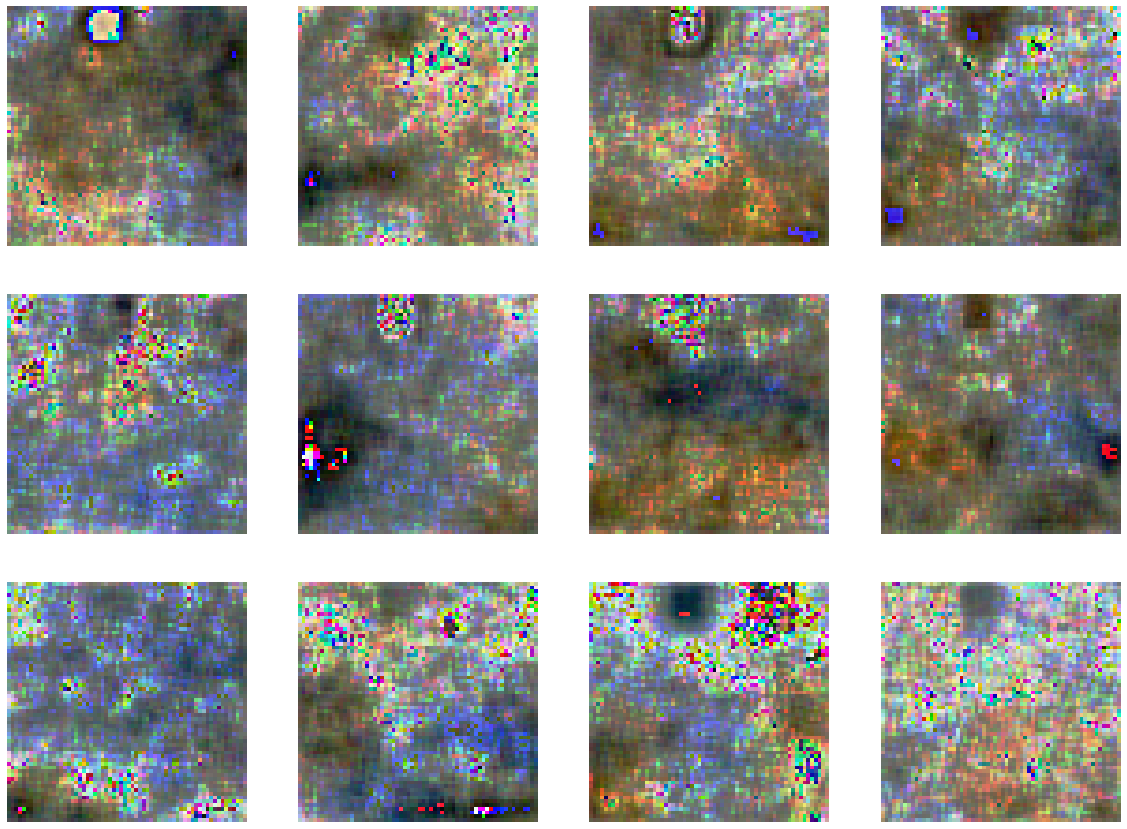

10/10 [==============================] - 7s 751ms/step - c_loss: -39.8102 - g_loss: -361.3132


In [43]:
EPOCHS = 1
setup_folders(FOLDERS_TO_SETUP)
history = wgan.fit(train_dataset, shuffle=True, epochs=EPOCHS, callbacks=[gan_monitor], verbose=1)

In [44]:
history.history

{'c_loss': [-36.39733123779297], 'g_loss': [-357.68939208984375]}

In [31]:
def save_models():
	wgan.generator.model.save(CWD/'generator')
	wgan.critic.model.save(CWD/'critic')

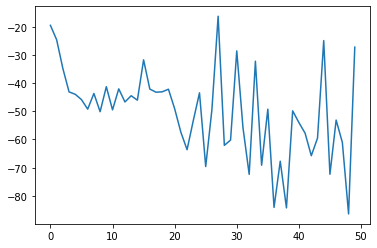

In [35]:
plt.plot(wgan.history.history['c_loss'])

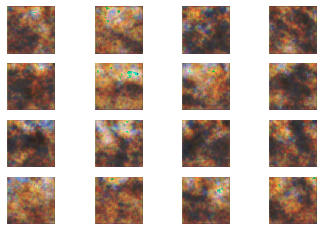

In [33]:
noise = tf.random.normal((16, 100))
generated_images = wgan.generator(noise)
generated_images = denormalize_images(generated_images)

display.clear_output(True)

for i in range(16):
	plt.subplot(4, 4, i+1)
	plt.imshow(generated_images[i])
	plt.axis('off')

plt.show()

TODO:
- tune hyperparameters
- maybe add loss to make output pictures more vibrant
- check for reasons for 'noise explosions' in output


- prepare model for being trained on cloud, kaggle and / or google colab
- see how to increase hardware usage, multi core processing and on cloud tpu usage
	-> auto tune shenanigans, distribution strategy and so on

#### refrences
http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson5/WGAN-GP.pdf  
https://keras.io/examples/generative/wgan_gp/  
https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://developers.google.com/machine-learning/gan/loss  
https://www.youtube.com/watch?v=pG0QZ7OddX4  
https://distill.pub/2016/deconv-checkerboard/  